In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from yellowbrick.classifier import ClassificationReport

In [4]:
#load data
df = pd.read_csv('Data/Final_Data.txt', sep='\t')
df.head(10)

,npi,nppes_provider_gender,specialty_description,medicare_prvdr_enroll_status,total_claim_count,total_30_day_fill_count,total_drug_cost,total_day_supply,bene_count,ge65_suppress_flag,...,country,state,nppes_credentials,total_30_day_per_claim,drug_cost_per_claim,day_supply_per_claim,female_count,male_count,nondual_count,dual_count
0,1770515488,M,Physical Medicine,E,629.0,654.0,44696.90,15538.0,204.0,not_suppressed,...,US,NY,Optometrist,1.039746,71.060254,24.702703,not suppressed,not suppressed,not suppressed,not suppressed
1,1174060784,F,Nurse,E,673.0,727.0,25846.34,19758.0,65.0,not_suppressed,...,US,NY,Nurse,1.080238,38.404666,29.358098,not suppressed,not suppressed,not suppressed,not suppressed
2,1265525273,M,Optometry/Ophthalmology,E,9103.0,10068.9,334417.10,257126.0,1481.0,not_suppressed,...,US,AT,Medical Doctor,1.106108,36.737021,28.246292,not suppressed,not suppressed,not suppressed,not suppressed
3,1306821152,M,Cardiologist,E,1359.0,3290.3,89341.59,98467.0,288.0,not_suppressed,...,US,NY,Medical Doctor,2.421118,65.740684,72.455482,not suppressed,not suppressed,not suppressed,not suppressed
4,1134244007,F,Internal Medicine,E,53.0,53.2,3391.01,579.0,25.0,counter suppressed,...,US,FL,Medical Doctor,1.003774,63.981321,10.924528,suppressed,suppressed,suppressed,suppressed
5,1386952299,M,Student,E,42.0,42.1,1560.65,1126.0,5.0,not_suppressed,...,US,MA,unknown,1.002381,37.158333,26.809524,suppressed,suppressed,suppressed,suppressed
6,1396739082,M,Optometry/Ophthalmology,E,136.0,170.1,16581.69,4284.0,37.0,not_suppressed,...,US,IA,Optometrist,1.250735,121.924191,31.500000,not suppressed,not suppressed,not suppressed,not suppressed
7,1558355438,M,Internal Medicine,E,17662.0,23457.2,750401.54,644674.0,635.0,not_suppressed,...,US,KY,Medical Doctor,1.328117,42.486782,36.500623,not suppressed,not suppressed,not suppressed,not suppressed
8,1588875850,M,Dentist,N,54.0,54.0,145.42,279.0,38.0,not_suppressed,...,US,GA,Dentist/DDS,1.000000,2.692963,5.166667,not suppressed,not suppressed,not suppressed,not suppressed
9,1811296197,F,Physician Assistant,E,201.0,268.5,10344.08,6480.0,83.0,not_suppressed,...,US,FL,Physican Assistant,1.335821,51.463085,32.238806,not suppressed,not suppressed,not suppressed,not suppressed


In [5]:
df.columns

Index(['npi', 'nppes_provider_gender', 'specialty_description',
       'medicare_prvdr_enroll_status', 'total_claim_count',
       'total_30_day_fill_count', 'total_drug_cost', 'total_day_supply',
       'bene_count', 'ge65_suppress_flag', 'total_claim_count_ge65',
       'total_30_day_fill_count_ge65', 'total_drug_cost_ge65',
       'total_day_supply_ge65', 'bene_count_ge65_suppress_flag',
       'bene_count_ge65', 'brand_suppress_flag', 'brand_claim_count',
       'brand_drug_cost', 'generic_suppress_flag', 'generic_claim_count',
       'generic_drug_cost', 'other_suppress_flag', 'other_claim_count',
       'other_drug_cost', 'mapd_suppress_flag', 'mapd_claim_count',
       'mapd_drug_cost', 'pdp_suppress_flag', 'pdp_claim_count',
       'pdp_drug_cost', 'lis_suppress_flag', 'lis_claim_count',
       'lis_drug_cost', 'nonlis_suppress_flag', 'nonlis_claim_count',
       'nonlis_drug_cost', 'opioid_claim_count', 'opioid_drug_cost',
       'opioid_day_supply', 'opioid_bene_count', 'opio

In [6]:
df_revise = df.drop(columns = ['npi', 'specialty_description', 'EXCLYear', 'REINYear', 'excl_type', 'country', 'state', 'nppes_credentials'])

In [7]:
df_revise['nppes_provider_gender'] = df['nppes_provider_gender'].replace({'M': 1, 'F': 2})
df_revise['medicare_prvdr_enroll_status'] = df['medicare_prvdr_enroll_status'].replace({'E': 3, 'N': 2, 'O': 1})
suppress = ['ge65_suppress_flag', 'bene_count_ge65_suppress_flag', 'brand_suppress_flag','generic_suppress_flag', 
            'other_suppress_flag', 'mapd_suppress_flag', 'pdp_suppress_flag', 'lis_suppress_flag', 
            'nonlis_suppress_flag', 'antipsych_ge65_suppress_flag', 'antipsych_bene_ge65_suppress_flg']
df_revise[suppress] = df_revise[suppress].replace({'not_suppressed': 1, 'not suppressed': 1, 'suppressed': 2, 'counter suppressed': 3})
category = ['female_count', 'male_count', 'nondual_count', 'dual_count']
df_revise[category] = df_revise[category].replace({'not suppressed': 2, 'suppressed': 1})

In [8]:
df_no_suppress = df_revise.drop(columns=df_revise[suppress].columns)

In [9]:
df_no_suppress = df_no_suppress.drop(columns=(df_no_suppress[category].columns))

In [10]:
df_no_suppress.columns

Index(['nppes_provider_gender', 'medicare_prvdr_enroll_status',
       'total_claim_count', 'total_30_day_fill_count', 'total_drug_cost',
       'total_day_supply', 'bene_count', 'total_claim_count_ge65',
       'total_30_day_fill_count_ge65', 'total_drug_cost_ge65',
       'total_day_supply_ge65', 'bene_count_ge65', 'brand_claim_count',
       'brand_drug_cost', 'generic_claim_count', 'generic_drug_cost',
       'other_claim_count', 'other_drug_cost', 'mapd_claim_count',
       'mapd_drug_cost', 'pdp_claim_count', 'pdp_drug_cost', 'lis_claim_count',
       'lis_drug_cost', 'nonlis_claim_count', 'nonlis_drug_cost',
       'opioid_claim_count', 'opioid_drug_cost', 'opioid_day_supply',
       'opioid_bene_count', 'opioid_prescriber_rate', 'la_opioid_claim_count',
       'la_opioid_drug_cost', 'la_opioid_day_supply', 'la_opioid_bene_count',
       'la_opioid_prescriber_rate', 'antibiotic_claim_count',
       'antibiotic_drug_cost', 'antibiotic_bene_count',
       'antipsych_claim_count_ge

In [11]:
#Taking variables that make sense as predictive based on reading and data review
keep = ['medicare_prvdr_enroll_status', 'bene_count', 'bene_count_ge65', 'total_claim_count_ge65', 'brand_claim_count', 
        'generic_drug_cost', 'other_drug_cost', 'mapd_drug_cost', 'pdp_claim_count', 'lis_claim_count', 
       'nonlis_drug_cost', 'opioid_claim_count', 'la_opioid_bene_count', 'la_opioid_day_supply', 'opioid_prescriber_rate', 
       'la_opioid_prescriber_rate', 'antipsych_drug_cost_ge65', 'antibiotic_drug_cost', 'average_age_of_beneficiaries', 
       'beneficiary_dual_count', 'day_supply_per_claim', 'drug_cost_per_claim', 'exclusion_flag']
df_model1 = df_no_suppress[keep]

In [12]:
features = df_model1.drop(columns = ['exclusion_flag'])
labels   = df_model1['exclusion_flag']

## Transformer Methods

In [13]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['bene_count_ge65', 'total_claim_count_ge65', 'lis_claim_count', 'opioid_claim_count']


In [14]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['medicare_prvdr_enroll_status']


In [15]:
model = ElasticNet()
sfm = SelectFromModel(model)
sfm.fit(features, labels)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['bene_count_ge65', 'total_claim_count_ge65', 'opioid_claim_count', 'beneficiary_dual_count']


In [16]:
df_model1.columns

Index(['medicare_prvdr_enroll_status', 'bene_count', 'bene_count_ge65',
       'total_claim_count_ge65', 'brand_claim_count', 'generic_drug_cost',
       'other_drug_cost', 'mapd_drug_cost', 'pdp_claim_count',
       'lis_claim_count', 'nonlis_drug_cost', 'opioid_claim_count',
       'la_opioid_bene_count', 'la_opioid_day_supply',
       'opioid_prescriber_rate', 'la_opioid_prescriber_rate',
       'antipsych_drug_cost_ge65', 'antibiotic_drug_cost',
       'average_age_of_beneficiaries', 'beneficiary_dual_count',
       'day_supply_per_claim', 'drug_cost_per_claim', 'exclusion_flag'],
      dtype='object')

In [17]:
#Changing sample data
#Filtering to only the excluded rows
excluded = df_model1['exclusion_flag'] == 1
df_excluded = df_model1[excluded]

In [18]:
#Filtering to only non-excluded rows
not_excluded = df_model1['exclusion_flag'] == 0
df_not_excluded = df_model1[not_excluded]
df_not_excluded.shape

(4535, 23)

In [19]:
#Randomly samping the non excluded component
df_random = df_not_excluded.sample(n=500)
df_random.shape

(500, 23)

In [20]:
#Appending the randomly selected rows and the excluded rows
df_final = df_random.append(df_excluded, ignore_index = True)

In [21]:
df_final['exclusion_flag'].value_counts()

0    500
1    465
Name: exclusion_flag, dtype: int64

In [22]:
features = df_final.drop(columns = ['exclusion_flag']).columns
target   = ['exclusion_flag']
X = df_final[features]
y = df_final[target]

# Models with Scaling the data

When investigating options for scaling, the MinMaxScaler and MaxAbsScaler were discarded as options as they are sensitive to outliers. Therefore, investigated using both the RobustScaler Standard Scalar.

## RobustScaler

In [23]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler(quantile_range = (0.1,0.9))
X_std = robust.fit_transform(X)

In [24]:
def score_model(X_std, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
   # y = LabelEncoder().fit_transform(y)    #already one hot encoded so this is commented out
    #model = Pipeline([
     #    ('one_hot_encoder', OneHotEncoder()), 
      #   ('estimator', estimator)
    #])

    # Instantiate the classification model and visualizer
    model.fit(X_std, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X_std)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [26]:
#Class imbalance and Scaler adjustments
models = [
    SVC(gamma='auto', class_weight='balanced'), NuSVC(nu= 0.1, gamma='auto', class_weight='balanced'), 
    KNeighborsClassifier(), LinearSVC(class_weight='balanced'), 
    SGDClassifier(max_iter=100, tol=1e-3, class_weight='balanced'), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100, class_weight='balanced'), 
    BalancedRandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_std, y, model)

SVC: 0.7891304347826088
NuSVC: 0.8138351983723296
KNeighborsClassifier: 0.7977528089887641
LinearSVC: 0.7652173913043478
SGDClassifier: 0.6825396825396824
LogisticRegression: 0.7630434782608696
LogisticRegressionCV: 0.7579408543263965
BaggingClassifier: 0.9803921568627451
ExtraTreesClassifier: 1.0
BalancedRandomForestClassifier: 0.9819724284199364


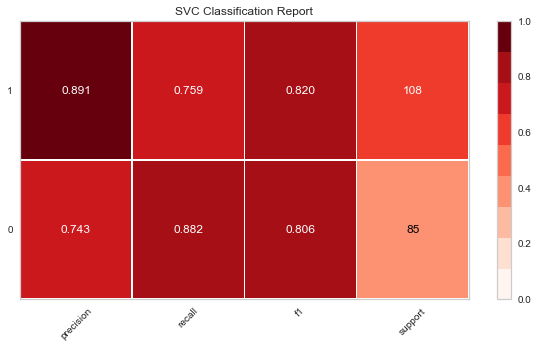

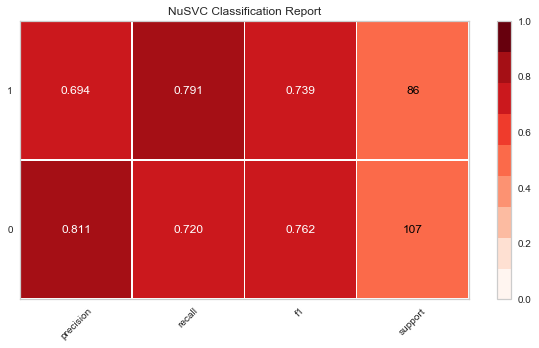

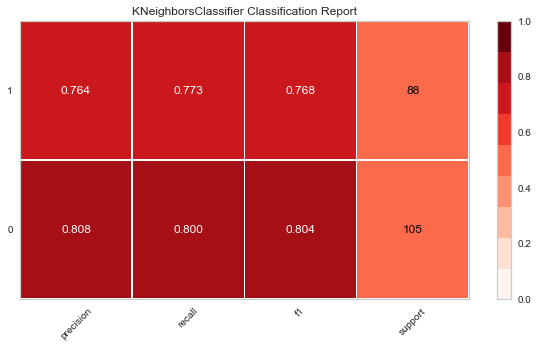

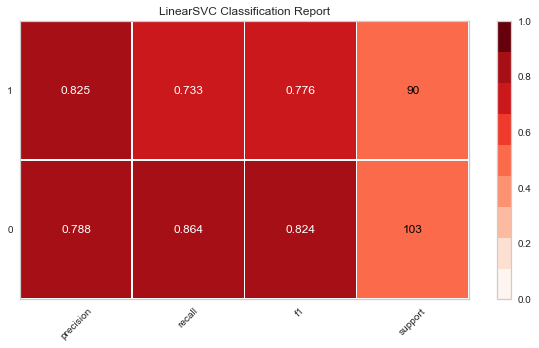

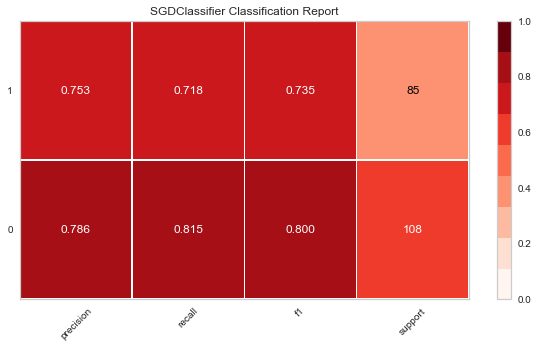

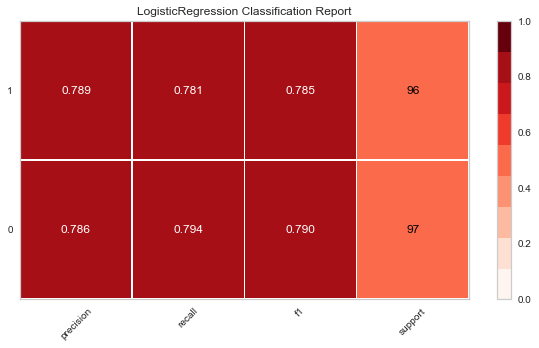

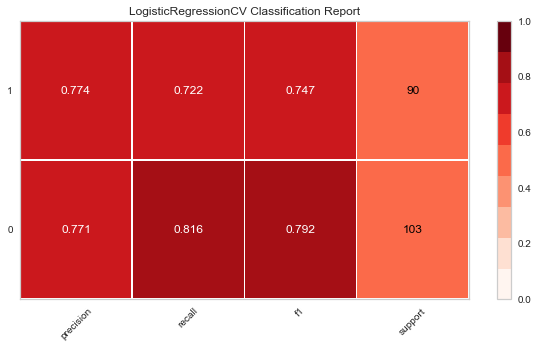

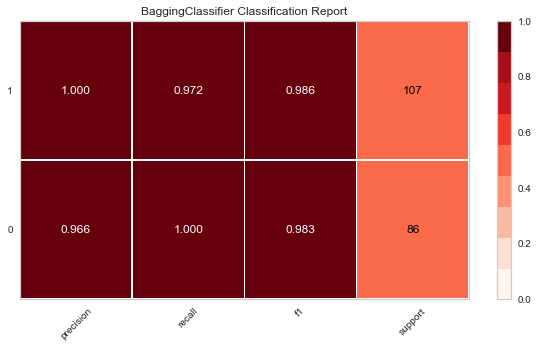

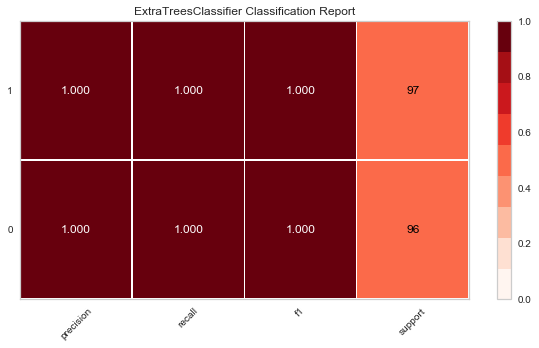

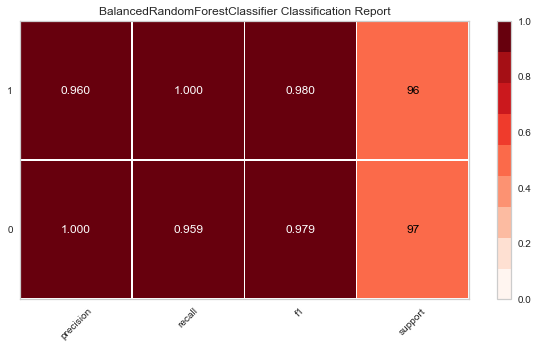

In [27]:
def visualize_model(X_std, y, estimator):
    """
    Test various estimators.
    """ 
    #y = LabelEncoder().fit_transform(y)
    #model = Pipeline([
     #    ('one_hot_encoder', OneHotEncoder()), 
      #   ('estimator', estimator)
    #])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['0', '1'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X_std, y, test_size=0.20)
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X_std, y, model)

## StandardScaler

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [29]:
def score_model(X_std, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
   # y = LabelEncoder().fit_transform(y)    #already one hot encoded so this is commented out
    #model = Pipeline([
     #    ('one_hot_encoder', OneHotEncoder()), 
      #   ('estimator', estimator)
    #])

    # Instantiate the classification model and visualizer
    model.fit(X_std, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X_std)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [30]:
#Class imbalance and Scaler adjustments
models = [
    SVC(gamma='auto', class_weight='balanced'), NuSVC(nu= 0.1, gamma='auto', class_weight='balanced'), 
    KNeighborsClassifier(), LinearSVC(class_weight='balanced'), 
    SGDClassifier(max_iter=100, tol=1e-3, class_weight='balanced'), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100, class_weight='balanced'), 
    BalancedRandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_std, y, model)

SVC: 0.7891304347826088
NuSVC: 0.8138351983723296
KNeighborsClassifier: 0.7977528089887641
LinearSVC: 0.7641921397379912
SGDClassifier: 0.7320410490307867
LogisticRegression: 0.7630434782608696
LogisticRegressionCV: 0.7579408543263965
BaggingClassifier: 0.9880564603691641
ExtraTreesClassifier: 1.0
BalancedRandomForestClassifier: 0.9807692307692307


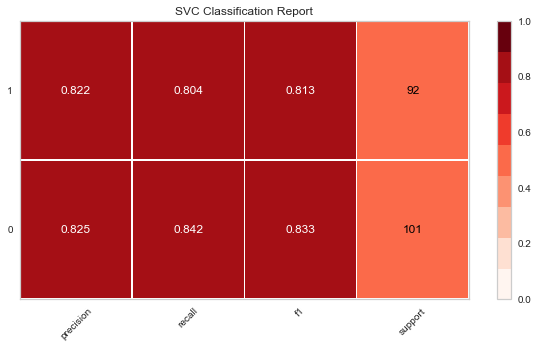

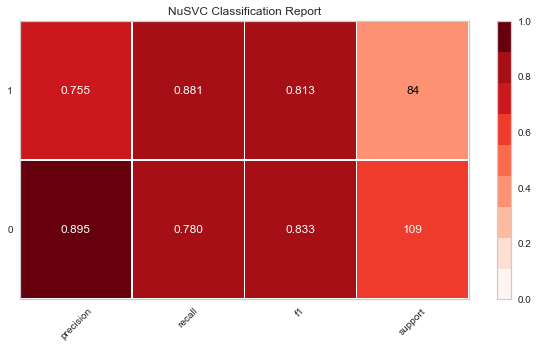

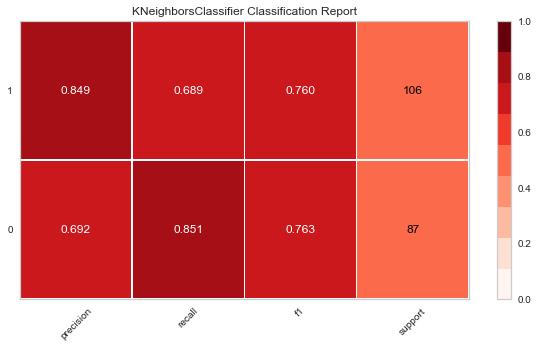

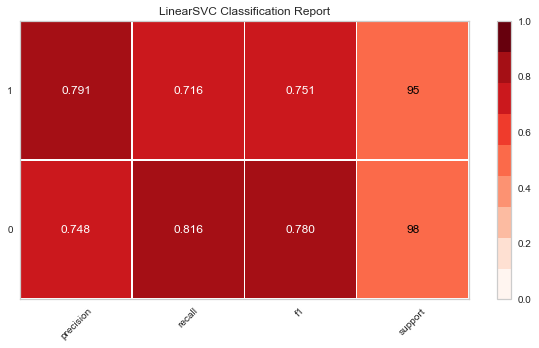

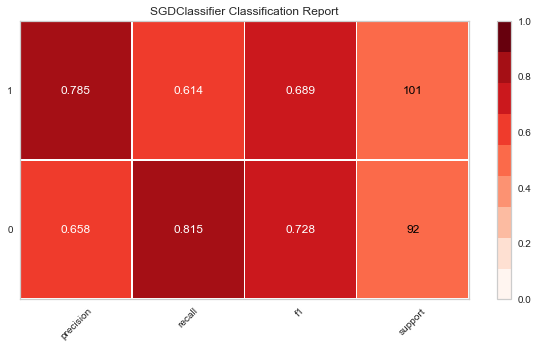

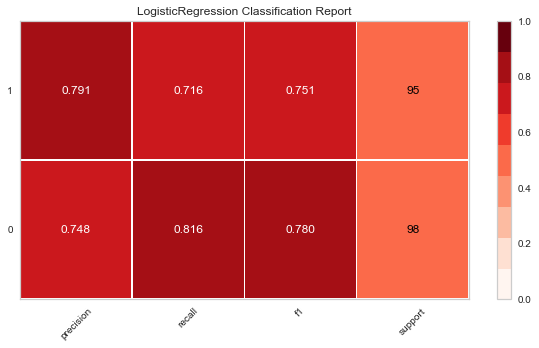

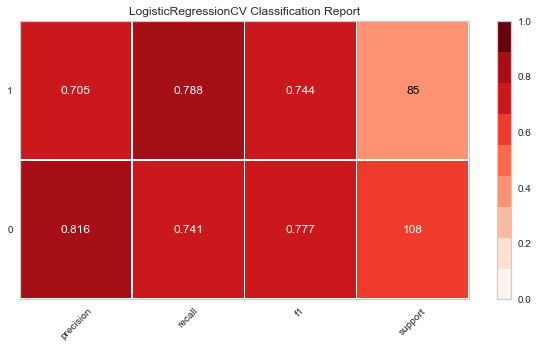

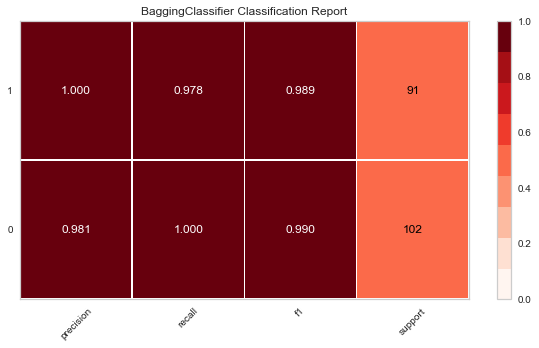

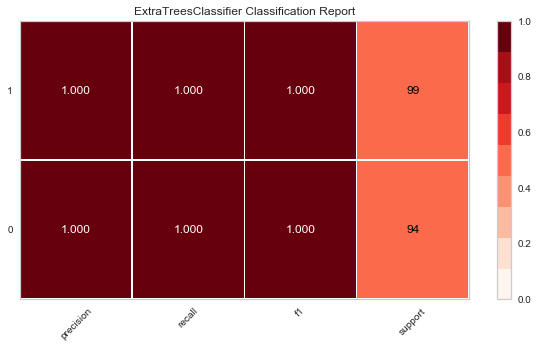

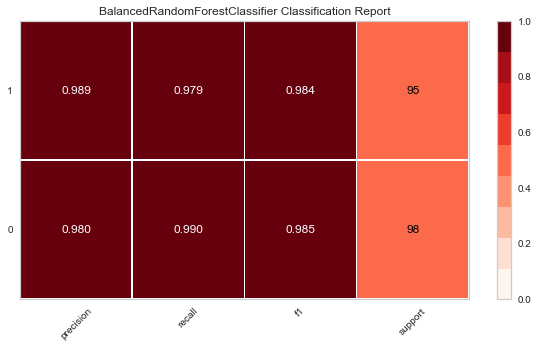

In [31]:
def visualize_model(X_std, y, estimator):
    """
    Test various estimators.
    """ 
    #y = LabelEncoder().fit_transform(y)
    #model = Pipeline([
     #    ('one_hot_encoder', OneHotEncoder()), 
      #   ('estimator', estimator)
    #])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['0', '1'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X_std, y, test_size=0.20)
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X_std, y, model)

## Feature Adjustments

The StandardScaler appeared to work better so will make feature analysis focused on these models

<bound method Visualizer.show of FeatureImportances(absolute=False,
          ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000195250C7588>,
          colormap=None, colors=None, is_fitted='auto',
          labels=Index(['medicare_prvdr_enroll_status', 'bene_count', 'bene_count_ge65',
       'total_claim_count_ge65', 'brand_claim_count', 'generic_drug_cost',
       'other_drug_cost', 'mapd_drug_cost', 'pdp_claim_count',
       'lis_claim_count', 'nonlis_drug_cost', 'opioid_claim_count',
       'la_opio...eneficiary_dual_count',
       'day_supply_per_claim', 'drug_cost_per_claim'],
      dtype='object'),
          model=None, relative=True, stack=False, xlabel=None)>

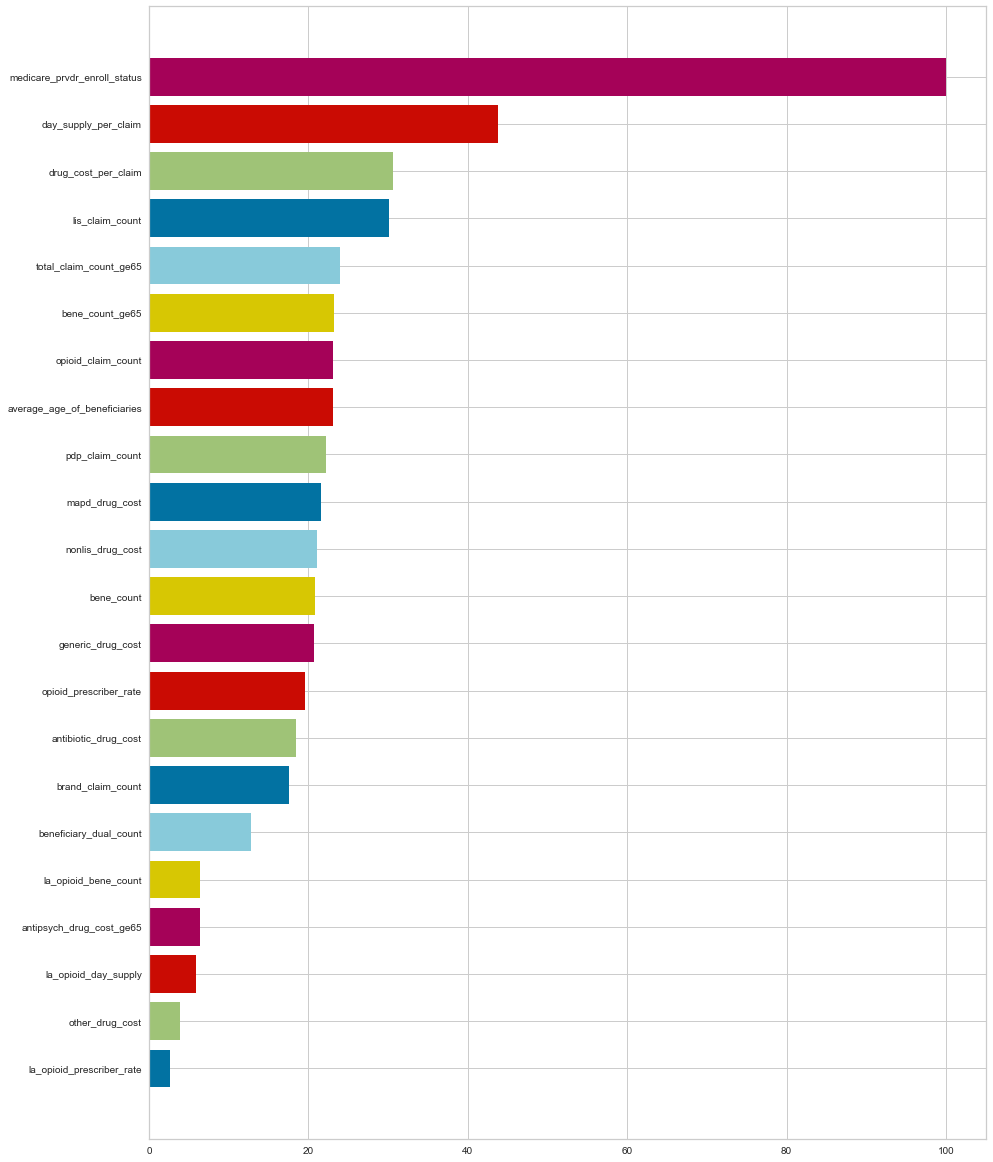

In [32]:
from yellowbrick.features import FeatureImportances

model= BalancedRandomForestClassifier()
viz=FeatureImportances(model, labels=features, size=(1080, 1500))
viz.fit(X_std, y)
viz.show

In [33]:
#Running models again after dropping the bottom 5 features
features = df_final.drop(columns = ['exclusion_flag', 'la_opioid_bene_count', 'la_opioid_day_supply', 
                                     'other_drug_cost', 'antipsych_drug_cost_ge65', 'la_opioid_prescriber_rate']).columns
target   = ['exclusion_flag']
X = df_final[features]
y = df_final[target]

In [34]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [35]:
def score_model(X_std, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
   # y = LabelEncoder().fit_transform(y)    #already one hot encoded so this is commented out
    #model = Pipeline([
     #    ('one_hot_encoder', OneHotEncoder()), 
      #   ('estimator', estimator)
    #])

    # Instantiate the classification model and visualizer
    model.fit(X_std, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X_std)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [36]:
#Running all models
models = [
    SVC(gamma='auto', class_weight='balanced'), NuSVC(nu= 0.1, gamma='auto', class_weight='balanced'), 
    KNeighborsClassifier(), LinearSVC(class_weight='balanced'), 
    SGDClassifier(max_iter=100, tol=1e-3, class_weight='balanced'), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100, class_weight='balanced'), 
    BalancedRandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X_std, y, model)

SVC: 0.789071038251366
NuSVC: 0.7645687645687645
KNeighborsClassifier: 0.8031496062992125
LinearSVC: 0.7599118942731278
SGDClassifier: 0.660393498716852
LogisticRegression: 0.756043956043956
LogisticRegressionCV: 0.7546754675467546
BaggingClassifier: 0.9727965179542982
ExtraTreesClassifier: 1.0
BalancedRandomForestClassifier: 0.9829787234042553


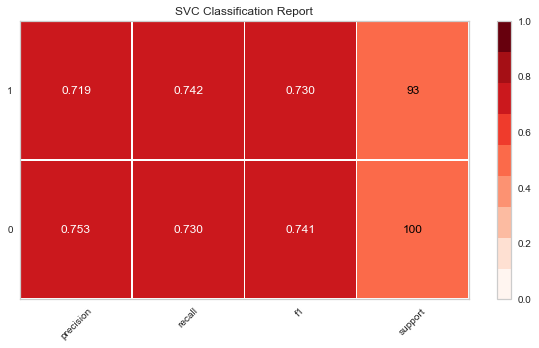

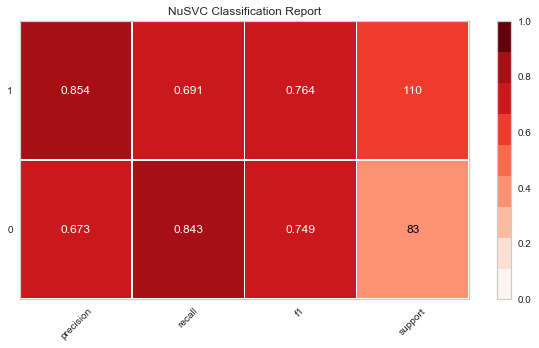

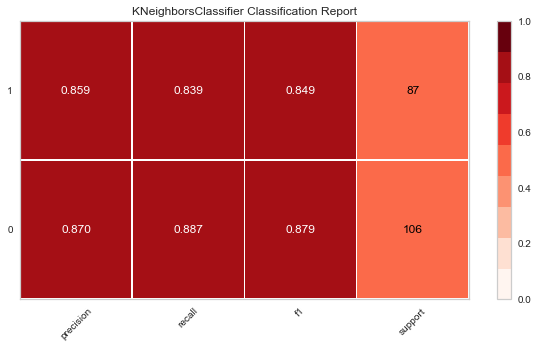

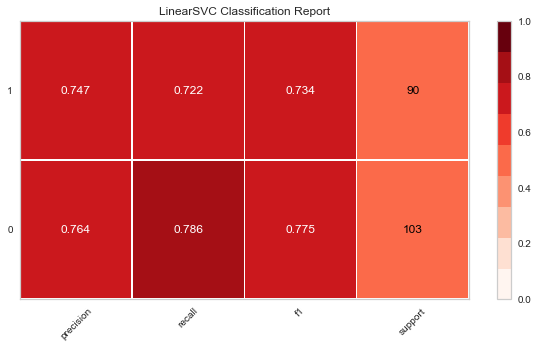

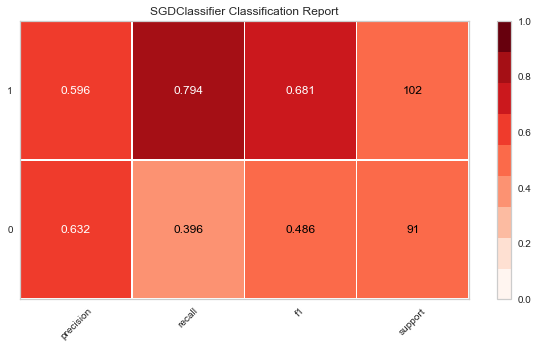

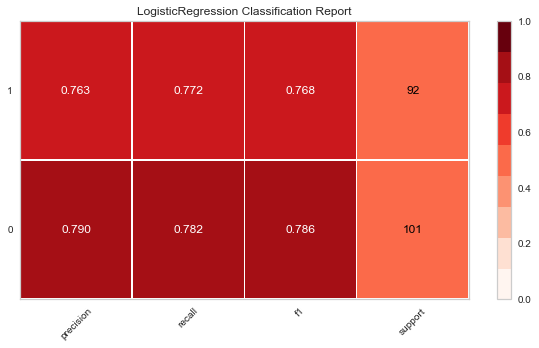

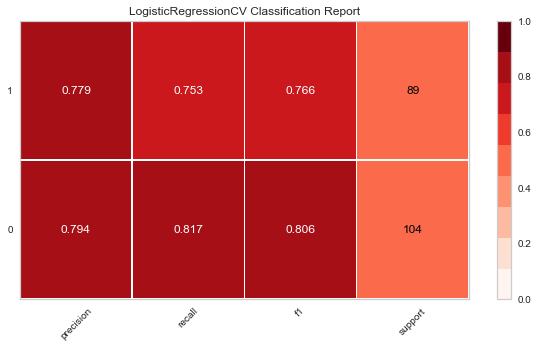

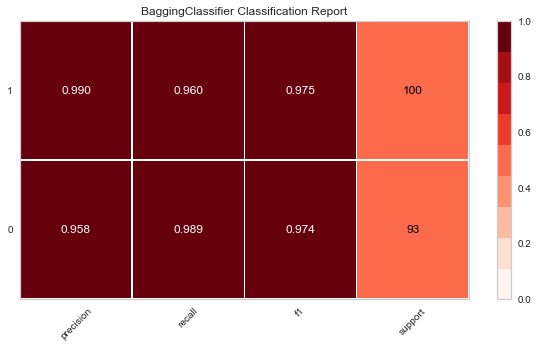

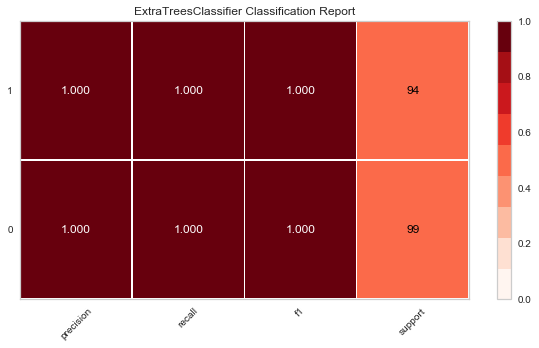

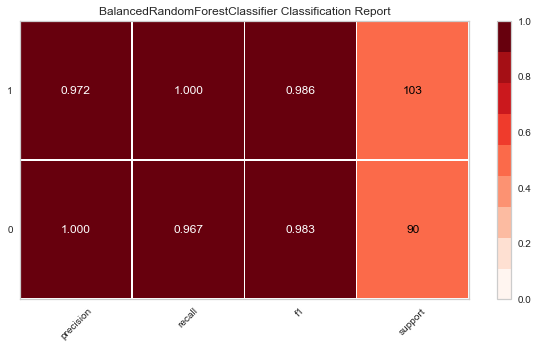

In [37]:
def visualize_model(X_std, y, estimator):
    """
    Test various estimators.
    """ 
    #y = LabelEncoder().fit_transform(y)
    #model = Pipeline([
     #    ('one_hot_encoder', OneHotEncoder()), 
      #   ('estimator', estimator)
    #])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['0', '1'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X_std, y, test_size=0.20)
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X_std, y, model)

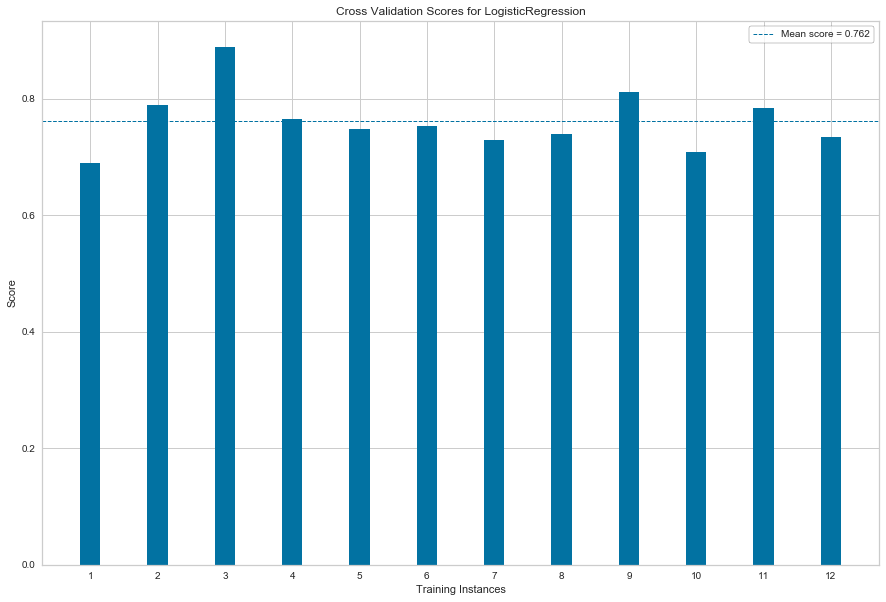

In [38]:
# Create a cross-validation strategy for the two top performing models
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores

cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = LogisticRegression(solver='lbfgs')
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(1080, 720)
)

visualizer.fit(X_std, y)
visualizer.show()

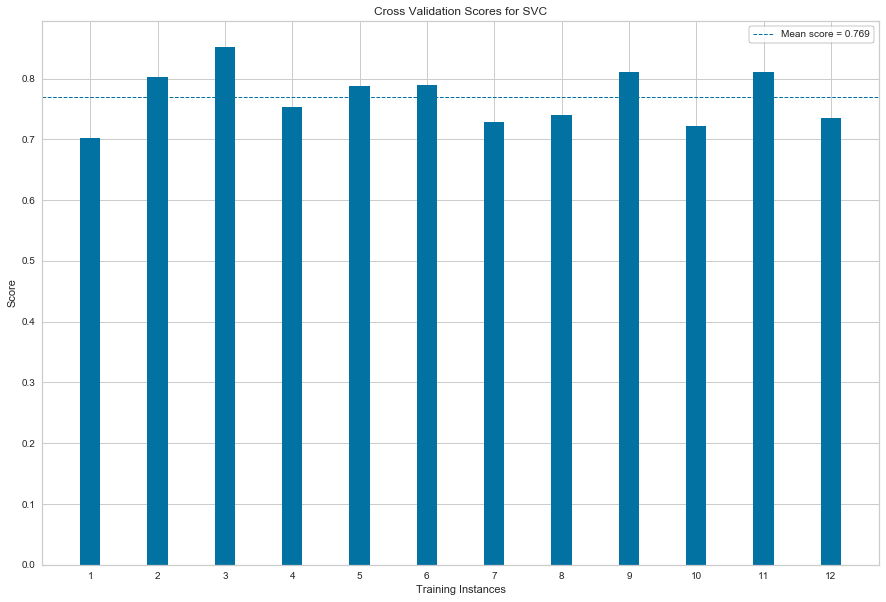

In [39]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = SVC(gamma='auto', class_weight='balanced')
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(1080, 720)
)

visualizer.fit(X_std, y)
visualizer.show()